In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bigquery-geotab-intersection-congestion/sample_submission.csv
/kaggle/input/bigquery-geotab-intersection-congestion/submission_metric_map
/kaggle/input/bigquery-geotab-intersection-congestion/submission_metric_map.json
/kaggle/input/bigquery-geotab-intersection-congestion/train.csv
/kaggle/input/bigquery-geotab-intersection-congestion/test.csv
/kaggle/input/bigquery-geotab-intersection-congestion/BigQuery-Dataset-Access.md


In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

In [4]:
sub_sample = pd.read_csv('/kaggle/input/bigquery-geotab-intersection-congestion/sample_submission.csv')
sub_sample.head()

,TargetId,Target
0,0_0,0
1,0_1,0
2,0_2,0
3,0_3,0
4,0_4,0


In [5]:
train_df = pd.read_csv('/kaggle/input/bigquery-geotab-intersection-congestion/train.csv')
train_df.head()

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,...,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City
0,1921357,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
1,1921358,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,SE,SE,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
2,1921359,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
3,1921360,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,SE,SE,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
4,1921361,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta


In [6]:
test_df = pd.read_csv('/kaggle/input/bigquery-geotab-intersection-congestion/test.csv')
test_df.head()

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,Path,City
0,0,1,33.75094,-84.393032,Peachtree Street Southwest,Peachtree Street Southwest,NE,NE,0,0,6,Peachtree Street Southwest_NE_Peachtree Street...,Atlanta
1,1,1,33.75094,-84.393032,Peachtree Street Southwest,Mitchell Street Southwest,SW,SE,0,0,6,Peachtree Street Southwest_SW_Mitchell Street ...,Atlanta
2,2,1,33.75094,-84.393032,Peachtree Street Southwest,Peachtree Street Southwest,SW,SW,0,0,6,Peachtree Street Southwest_SW_Peachtree Street...,Atlanta
3,3,1,33.75094,-84.393032,Peachtree Street Southwest,Peachtree Street Southwest,NE,NE,1,0,6,Peachtree Street Southwest_NE_Peachtree Street...,Atlanta
4,4,1,33.75094,-84.393032,Peachtree Street Southwest,Peachtree Street Southwest,SW,SW,1,0,6,Peachtree Street Southwest_SW_Peachtree Street...,Atlanta


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856387 entries, 0 to 856386
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   RowId                    856387 non-null  int64  
 1   IntersectionId           856387 non-null  int64  
 2   Latitude                 856387 non-null  float64
 3   Longitude                856387 non-null  float64
 4   EntryStreetName          848239 non-null  object 
 5   ExitStreetName           850100 non-null  object 
 6   EntryHeading             856387 non-null  object 
 7   ExitHeading              856387 non-null  object 
 8   Hour                     856387 non-null  int64  
 9   Weekend                  856387 non-null  int64  
 10  Month                    856387 non-null  int64  
 11  Path                     856387 non-null  object 
 12  TotalTimeStopped_p20     856387 non-null  float64
 13  TotalTimeStopped_p40     856387 non-null  float64
 14  Tota

In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1921357 entries, 0 to 1921356
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   RowId            int64  
 1   IntersectionId   int64  
 2   Latitude         float64
 3   Longitude        float64
 4   EntryStreetName  object 
 5   ExitStreetName   object 
 6   EntryHeading     object 
 7   ExitHeading      object 
 8   Hour             int64  
 9   Weekend          int64  
 10  Month            int64  
 11  Path             object 
 12  City             object 
dtypes: float64(2), int64(5), object(6)
memory usage: 190.6+ MB


In [9]:
print ("Common columns between Train & Test datasets :", np.intersect1d(train_df.columns, test_df.columns).tolist())

Common columns between Train & Test datasets : ['City', 'EntryHeading', 'EntryStreetName', 'ExitHeading', 'ExitStreetName', 'Hour', 'IntersectionId', 'Latitude', 'Longitude', 'Month', 'Path', 'RowId', 'Weekend']


In [10]:
print ("Columns in Train dataset only :", train_df.columns.symmetric_difference(test_df.columns).values )

Columns in Train dataset only : ['DistanceToFirstStop_p20' 'DistanceToFirstStop_p40'
 'DistanceToFirstStop_p50' 'DistanceToFirstStop_p60'
 'DistanceToFirstStop_p80' 'TimeFromFirstStop_p20' 'TimeFromFirstStop_p40'
 'TimeFromFirstStop_p50' 'TimeFromFirstStop_p60' 'TimeFromFirstStop_p80'
 'TotalTimeStopped_p20' 'TotalTimeStopped_p40' 'TotalTimeStopped_p50'
 'TotalTimeStopped_p60' 'TotalTimeStopped_p80']


# Data Cleaning

In [12]:
train_df.isnull().sum()

RowId                         0
IntersectionId                0
Latitude                      0
Longitude                     0
EntryStreetName            8148
ExitStreetName             6287
EntryHeading                  0
ExitHeading                   0
Hour                          0
Weekend                       0
Month                         0
Path                          0
TotalTimeStopped_p20          0
TotalTimeStopped_p40          0
TotalTimeStopped_p50          0
TotalTimeStopped_p60          0
TotalTimeStopped_p80          0
TimeFromFirstStop_p20         0
TimeFromFirstStop_p40         0
TimeFromFirstStop_p50         0
TimeFromFirstStop_p60         0
TimeFromFirstStop_p80         0
DistanceToFirstStop_p20       0
DistanceToFirstStop_p40       0
DistanceToFirstStop_p50       0
DistanceToFirstStop_p60       0
DistanceToFirstStop_p80       0
City                          0
dtype: int64

- There are missing values in the column EntryStreetName and ExitStreetName. We therefor drop rows with missing street names

In [14]:
train_df_clean = train_df.dropna(subset=['EntryStreetName', 'ExitStreetName'])
train_df_clean.isnull().sum().sum()

0

In [15]:
# check column datatypes
train_df_clean.dtypes

RowId                        int64
IntersectionId               int64
Latitude                   float64
Longitude                  float64
EntryStreetName             object
ExitStreetName              object
EntryHeading                object
ExitHeading                 object
Hour                         int64
Weekend                      int64
Month                        int64
Path                        object
TotalTimeStopped_p20       float64
TotalTimeStopped_p40       float64
TotalTimeStopped_p50       float64
TotalTimeStopped_p60       float64
TotalTimeStopped_p80       float64
TimeFromFirstStop_p20      float64
TimeFromFirstStop_p40      float64
TimeFromFirstStop_p50      float64
TimeFromFirstStop_p60      float64
TimeFromFirstStop_p80      float64
DistanceToFirstStop_p20    float64
DistanceToFirstStop_p40    float64
DistanceToFirstStop_p50    float64
DistanceToFirstStop_p60    float64
DistanceToFirstStop_p80    float64
City                        object
dtype: object

In [16]:
# For columns  EntryHeading, ExitHeading, City, convert them to categorical
train_df_clean['EntryHeading'].astype('category')
train_df_clean['ExitHeading'].astype('category')
train_df_clean['City'].astype('category')
train_df_clean.dtypes

RowId                        int64
IntersectionId               int64
Latitude                   float64
Longitude                  float64
EntryStreetName             object
ExitStreetName              object
EntryHeading                object
ExitHeading                 object
Hour                         int64
Weekend                      int64
Month                        int64
Path                        object
TotalTimeStopped_p20       float64
TotalTimeStopped_p40       float64
TotalTimeStopped_p50       float64
TotalTimeStopped_p60       float64
TotalTimeStopped_p80       float64
TimeFromFirstStop_p20      float64
TimeFromFirstStop_p40      float64
TimeFromFirstStop_p50      float64
TimeFromFirstStop_p60      float64
TimeFromFirstStop_p80      float64
DistanceToFirstStop_p20    float64
DistanceToFirstStop_p40    float64
DistanceToFirstStop_p50    float64
DistanceToFirstStop_p60    float64
DistanceToFirstStop_p80    float64
City                        object
dtype: object

# EDA

In [17]:
# Basic descriptive statistics of numeric columns
train_df_clean.describe()

,RowId,IntersectionId,Latitude,Longitude,Hour,Weekend,Month,TotalTimeStopped_p20,TotalTimeStopped_p40,TotalTimeStopped_p50,...,TimeFromFirstStop_p20,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80
count,8.424520e+05,842452.000000,842452.000000,842452.000000,842452.000000,842452.000000,842452.000000,842452.000000,842452.000000,842452.000000,...,842452.000000,842452.000000,842452.000000,842452.000000,842452.000000,842452.000000,842452.000000,842452.000000,842452.000000,842452.000000
mean,2.351367e+06,837.150963,39.643732,-77.897480,12.430385,0.278895,9.104089,1.712640,5.315217,7.614452,...,3.113625,9.041365,12.583435,18.765524,34.003984,6.665580,20.157423,28.726120,44.218243,84.084817
std,2.467677e+05,655.732079,2.915619,5.951687,6.077999,0.448456,1.991233,7.028749,12.817806,15.507983,...,11.679443,20.270912,24.041641,29.667963,40.930126,29.482647,59.352436,75.467894,102.451157,161.351305
min,1.921357e+06,0.000000,33.649973,-87.862288,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.138701e+06,292.000000,39.937602,-84.387454,8.000000,0.000000,7.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.351786e+06,685.000000,39.984711,-75.174634,13.000000,0.000000,9.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,60.400000
75%,2.564918e+06,1268.000000,41.910407,-75.099312,17.000000,1.000000,11.000000,0.000000,0.000000,10.000000,...,0.000000,0.000000,21.000000,31.000000,48.000000,0.000000,0.000000,52.900000,64.100000,85.800000
max,2.777743e+06,2875.000000,42.381782,-71.025550,23.000000,1.000000,12.000000,298.000000,375.000000,375.000000,...,337.000000,356.000000,356.000000,357.000000,359.000000,1901.900000,2844.400000,2851.100000,3282.400000,4079.200000


In [18]:
# Descriptive statistics of the "Total time stopped"
train_df_clean[['TotalTimeStopped_p20','TotalTimeStopped_p40','TotalTimeStopped_p50',
          'TotalTimeStopped_p60','TotalTimeStopped_p80']].describe().T

,count,mean,std,min,25%,50%,75%,max
TotalTimeStopped_p20,842452.0,1.712640,7.028749,0.0,0.0,0.0,0.0,298.0
TotalTimeStopped_p40,842452.0,5.315217,12.817806,0.0,0.0,0.0,0.0,375.0
TotalTimeStopped_p50,842452.0,7.614452,15.507983,0.0,0.0,0.0,10.0,375.0
TotalTimeStopped_p60,842452.0,11.787859,19.557800,0.0,0.0,0.0,18.0,377.0
TotalTimeStopped_p80,842452.0,22.766657,28.033040,0.0,0.0,16.0,34.0,763.0


In [21]:
# Descriptive statistics of the "Time from first stop"
train_df_clean[['TimeFromFirstStop_p20','TimeFromFirstStop_p40', 'TimeFromFirstStop_p50','TimeFromFirstStop_p60',
          'TimeFromFirstStop_p80']].describe().T

,count,mean,std,min,25%,50%,75%,max
TimeFromFirstStop_p20,842452.0,3.113625,11.679443,0.0,0.0,0.0,0.0,337.0
TimeFromFirstStop_p40,842452.0,9.041365,20.270912,0.0,0.0,0.0,0.0,356.0
TimeFromFirstStop_p50,842452.0,12.583435,24.041641,0.0,0.0,0.0,21.0,356.0
TimeFromFirstStop_p60,842452.0,18.765524,29.667963,0.0,0.0,0.0,31.0,357.0
TimeFromFirstStop_p80,842452.0,34.003984,40.930126,0.0,0.0,26.0,48.0,359.0


In [22]:
# Descriptive statistics of the "•Distance to first stop"
train_df_clean[['DistanceToFirstStop_p20','DistanceToFirstStop_p40', 'DistanceToFirstStop_p50','DistanceToFirstStop_p60',
 'DistanceToFirstStop_p80']].describe().T

,count,mean,std,min,25%,50%,75%,max
DistanceToFirstStop_p20,842452.0,6.665580,29.482647,0.0,0.0,0.0,0.0,1901.9
DistanceToFirstStop_p40,842452.0,20.157423,59.352436,0.0,0.0,0.0,0.0,2844.4
DistanceToFirstStop_p50,842452.0,28.726120,75.467894,0.0,0.0,0.0,52.9,2851.1
DistanceToFirstStop_p60,842452.0,44.218243,102.451157,0.0,0.0,0.0,64.1,3282.4
DistanceToFirstStop_p80,842452.0,84.084817,161.351305,0.0,0.0,60.4,85.8,4079.2


In [23]:
# Averages per City based on 50 & 80 percentile
train_df_clean.groupby('City').agg({'TotalTimeStopped_p50':'mean','TimeFromFirstStop_p50':'mean','DistanceToFirstStop_p50':'mean','TotalTimeStopped_p80':'mean','TimeFromFirstStop_p80':'mean','DistanceToFirstStop_p80':'mean'})

,TotalTimeStopped_p50,TimeFromFirstStop_p50,DistanceToFirstStop_p50,TotalTimeStopped_p80,TimeFromFirstStop_p80,DistanceToFirstStop_p80
City,,,,,,
Atlanta,9.561990,15.007181,30.672577,28.661106,41.370694,105.777004
Boston,8.568312,13.193209,23.469332,25.920588,35.456078,62.896978
Chicago,7.088462,11.347119,24.580853,21.321645,30.943332,69.790891
Philadelphia,6.594667,11.773366,31.756791,19.508972,31.490082,90.069086


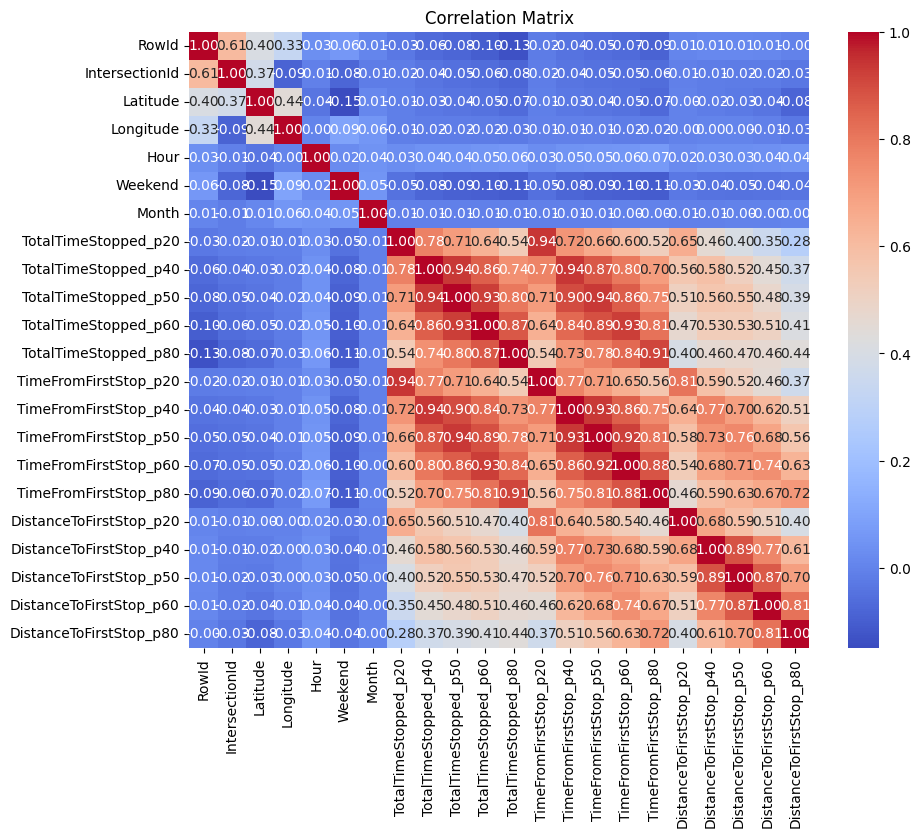

In [24]:
# Check correlation between features
# Select only numerical columns from the DataFrame
numerical_columns = train_df_clean.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix on numerical columns
correlation = numerical_columns.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

**Visualizes how TotalTimeStopped varies by Hour and Weekend status to find traffic patterns.**

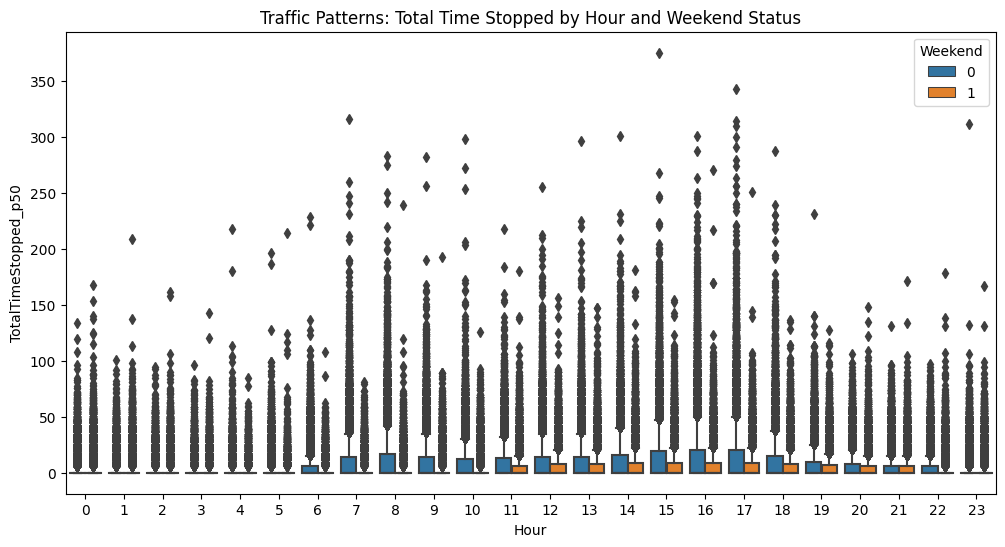

In [25]:
# traffic patterns by hour and weekend status
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df_clean, x='Hour', y='TotalTimeStopped_p50', hue='Weekend')
plt.title('Traffic Patterns: Total Time Stopped by Hour and Weekend Status')
plt.show()

**Show the distribution of data across the four cities in the dataset.**

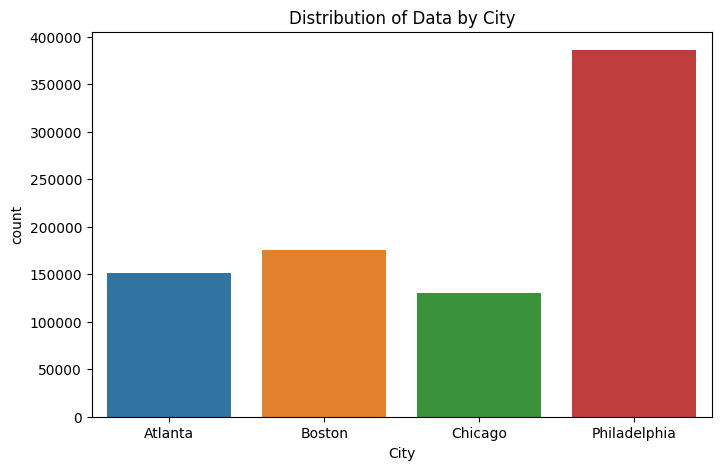

In [26]:
# Countplot for city distribution in training data
plt.figure(figsize=(8, 5))
sns.countplot(data=train_df_clean, x='City')
plt.title('Distribution of Data by City')
plt.show()

**Philadelphia seems to have the most data**

**Let's explore the relationship between TotalTimeStopped_p50 and DistanceToFirstStop_p50.**

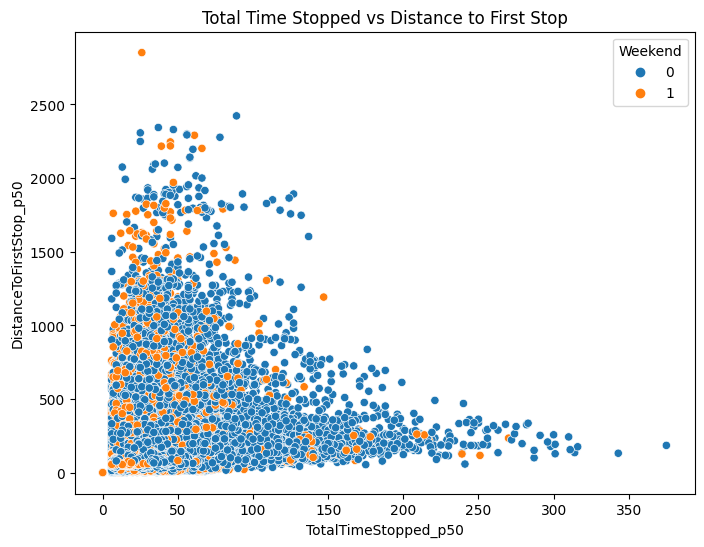

In [27]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_df_clean, x='TotalTimeStopped_p50', y='DistanceToFirstStop_p50', hue='Weekend')
plt.title('Total Time Stopped vs Distance to First Stop')
plt.show()

I don't seem to see a distinct relationship between the two variables

**Let us view how categorical variables: city and weekend impact the TotalTimeStopped and Distance to first Stopped**

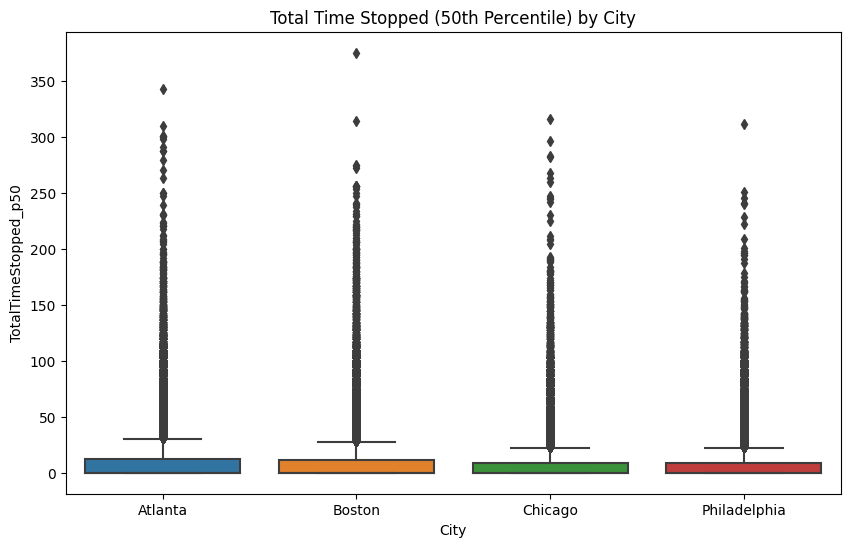

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df_clean, x='City', y='TotalTimeStopped_p50')
plt.title('Total Time Stopped (50th Percentile) by City')
plt.show()

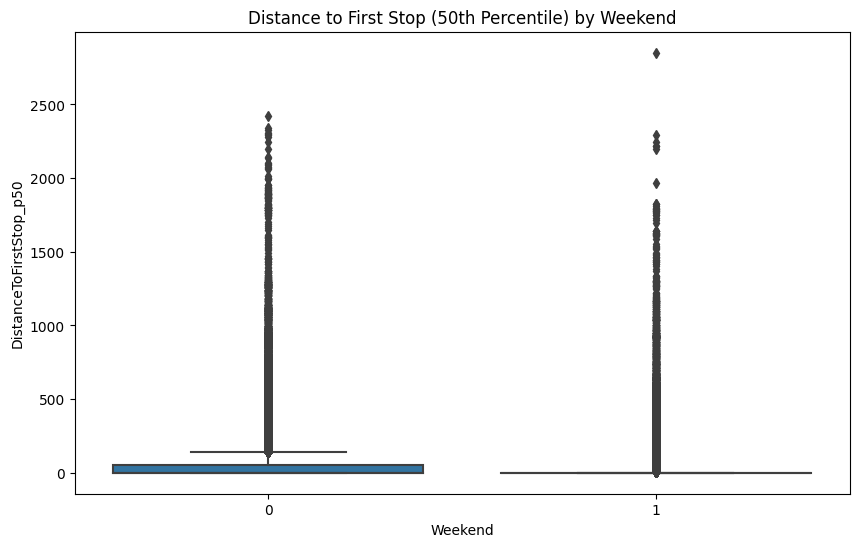

In [29]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df_clean, x='Weekend', y='DistanceToFirstStop_p50')
plt.title('Distance to First Stop (50th Percentile) by Weekend')
plt.show()

**Because we have latitudes and longitudes, we can visualize the data on a map/geographical scatter plot to see distributions on the intersections on a map**

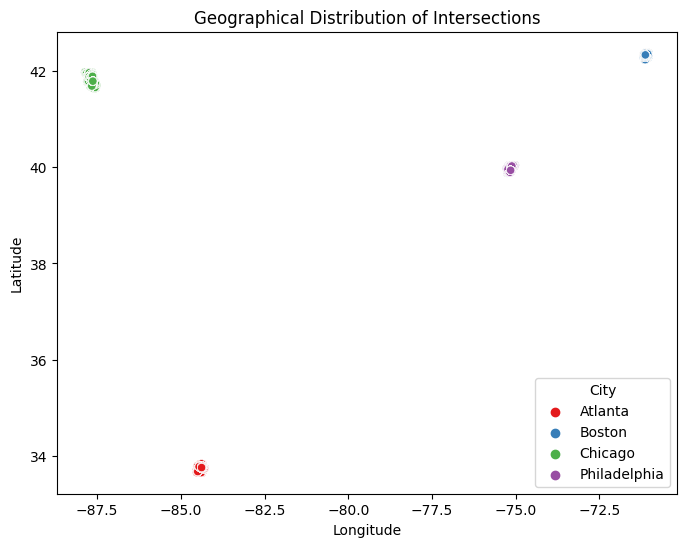

In [30]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_df_clean, x='Longitude', y='Latitude', hue='City', palette='Set1')
plt.title('Geographical Distribution of Intersections')
plt.show()

**Explore how traffic congestion varies by hour of the day.**

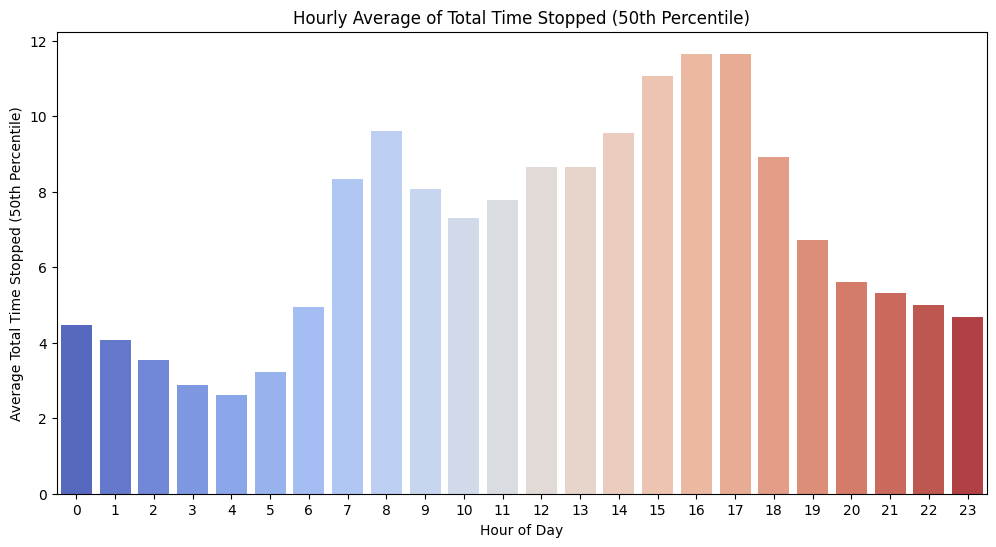

In [31]:
# Group by hour and calculate the mean
hourly_congestion = train_df_clean.groupby('Hour')['TotalTimeStopped_p50'].mean().reset_index()

# Plot using a barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='Hour', y='TotalTimeStopped_p50', data=hourly_congestion, palette='coolwarm')
plt.title('Hourly Average of Total Time Stopped (50th Percentile)')
plt.xlabel('Hour of Day')
plt.ylabel('Average Total Time Stopped (50th Percentile)')
plt.show()

**Traffic congestion seems to peek at afternoon to evening hours and also between 7 and 9 morning hours. These could be because these are hours people go to work and leave work**

# Hypotheses Testing

Is our data normally distributed or not so that we can know which test to use.

/tmp/ipykernel_30/2905285886.py:3: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


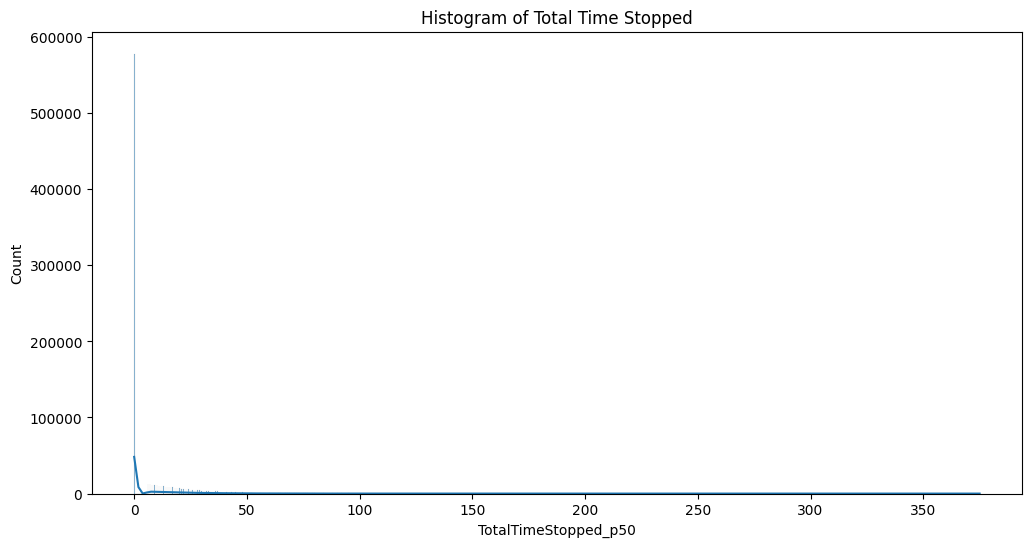

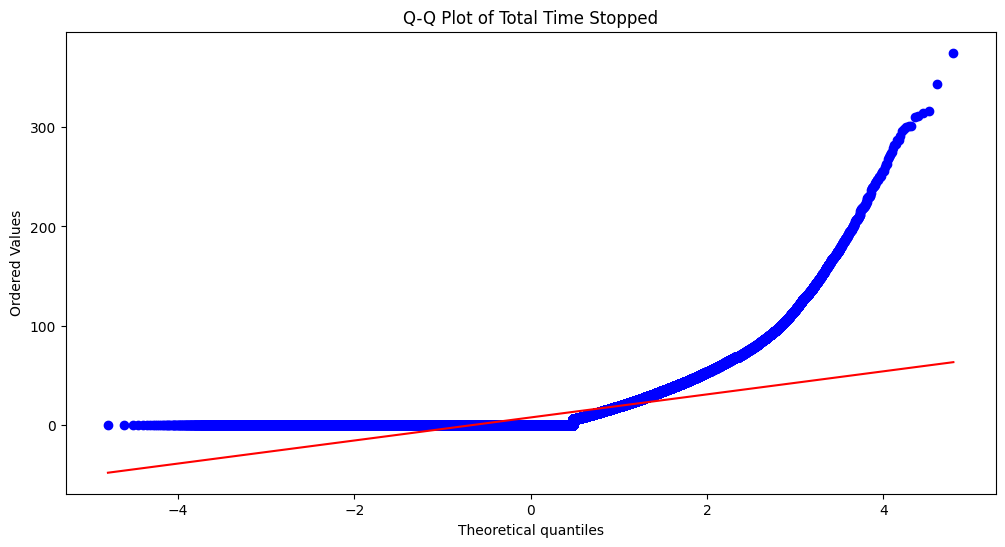

In [36]:
# check visually
# Histogram
with pd.option_context('mode.use_inf_as_na', True):
    plt.figure(figsize=(12, 6))
    sns.histplot(train_df_clean['TotalTimeStopped_p50'], kde=True)
    plt.title('Histogram of Total Time Stopped')
    plt.show()
    
    # Q-Q Plot
    plt.figure(figsize=(12, 6))
    stats.probplot(train_df_clean['TotalTimeStopped_p50'], dist="norm", plot=plt)
    plt.title('Q-Q Plot of Total Time Stopped')
    plt.show()

**Visually it seems not to be a normal distribution. LEt us further use a statistical test to second or visual analysis. We will use a Shapiro-Wilk Test and a  Kolmogorov-Smirnov Test where when we get a p-value of lower than 0.05 we will reject our null hypotheses which is the data is normally distributed**

In [38]:
from scipy.stats import shapiro

stat, p_value = shapiro(train_df_clean['TotalTimeStopped_p50'])
print(f'Shapiro-Wilk Test: Statistics={stat}, p-value={p_value}')
if p_value < 0.05:
    print("Data is not normally distributed")
else:
    print("Data is normally distributed")

Shapiro-Wilk Test: Statistics=0.5613500837621241, p-value=1.1526008036983287e-203
Data is not normally distributed


In [39]:
from scipy.stats import kstest

stat, p_value = kstest(train_df_clean['TotalTimeStopped_p50'], 'norm', args=(train_df_clean['TotalTimeStopped_p50'].mean(), train_df_clean['TotalTimeStopped_p50'].std()))
print(f'Kolmogorov-Smirnov Test: Statistics={stat}, p-value={p_value}')
if p_value < 0.05:
    print("Data is not normally distributed")
else:
    print("Data is normally distributed")

Kolmogorov-Smirnov Test: Statistics=0.3741342982646103, p-value=0.0
Data is not normally distributed


**We confirm that we have a non-normal distributed data**

## Hypotheses 1

**Hypothesis 1: There is a significant difference in total time stopped on weekends vs. weekdays.**

Since our data is not a normal distribution for our first hypotheses we will use a **Mann-Whitney U test**

In [41]:
from scipy.stats import mannwhitneyu

# Separate data into weekends and weekdays
weekend_data = train_df_clean[train_df_clean['Weekend'] == 1]['TotalTimeStopped_p50']
weekday_data = train_df_clean[train_df_clean['Weekend'] == 0]['TotalTimeStopped_p50']

# Since data is not normal, we will do a  Mann-Whitney U test
u_stat, p_val_mannwhitney = mannwhitneyu(weekend_data, weekday_data)

# Print results
print(f"Mann-Whitney U test: U-statistic = {u_stat}, p-value = {p_val_mannwhitney}")

Mann-Whitney U test: U-statistic = 64075342413.0, p-value = 0.0


**Given we get a p-value lower than 0.05, we reject the null hypothesis and conclude that there is a significant difference in total time stopped on weekends vs. weekdays.**

## Hypotheses 2

****Hypothesis 2: The direction (EntryHeading or ExitHeading) affects total time stopped.****

In [42]:
# To compare means we will use ANOVA
from scipy.stats import f_oneway

# Group data by EntryHeading and calculate total time stopped
grouped_by_entry = train_df_clean.groupby('EntryHeading')['TotalTimeStopped_p50'].apply(list)

# Perform ANOVA
f_stat, p_val_anova = f_oneway(*grouped_by_entry)

print(f"ANOVA: F-statistic = {f_stat}, p-value = {p_val_anova}")

ANOVA: F-statistic = 170.1745826942054, p-value = 8.477068904200256e-253


**We find that our p-value is below the threshold 0.05, so we reject the null hypothesis and conclude that direction impacts the total time stopped.**

## Hypotheses 3

**Hypothesis 3: The average total time stopped varies significantly between cities.**

In [43]:
# We will again use ANOVA
# Group data by City and calculate total time stopped
grouped_by_city = train_df_clean.groupby('City')['TotalTimeStopped_p50'].apply(list)

# Perform ANOVA
f_stat_city, p_val_anova_city = f_oneway(*grouped_by_city)

print(f"ANOVA by City: F-statistic = {f_stat_city}, p-value = {p_val_anova_city}")

ANOVA by City: F-statistic = 1630.5273643183332, p-value = 0.0


**P_value is below 0.05 indicating that we reject  null hypotheses hence indicating that mean total time stopped differs across the cities.**

# Modelling

## Preprocessing

In [44]:
train_df_clean.dtypes

RowId                        int64
IntersectionId               int64
Latitude                   float64
Longitude                  float64
EntryStreetName             object
ExitStreetName              object
EntryHeading                object
ExitHeading                 object
Hour                         int64
Weekend                      int64
Month                        int64
Path                        object
TotalTimeStopped_p20       float64
TotalTimeStopped_p40       float64
TotalTimeStopped_p50       float64
TotalTimeStopped_p60       float64
TotalTimeStopped_p80       float64
TimeFromFirstStop_p20      float64
TimeFromFirstStop_p40      float64
TimeFromFirstStop_p50      float64
TimeFromFirstStop_p60      float64
TimeFromFirstStop_p80      float64
DistanceToFirstStop_p20    float64
DistanceToFirstStop_p40    float64
DistanceToFirstStop_p50    float64
DistanceToFirstStop_p60    float64
DistanceToFirstStop_p80    float64
City                        object
dtype: object

**Features to be used in modeling**

In [46]:
features = ['IntersectionId', 'Latitude', 'Longitude', 'EntryStreetName', 'ExitStreetName', 'EntryHeading',
            'ExitHeading','Hour', 'Weekend','Month','Path','City']

_df_train = train_df_clean[features]
_df_test = test_df[features]

**Categorical variables in the data set should be converted into numerical values. For this reason, these transformation processes are performed with Label Encoding**

Create LabelEncoder object

In [49]:

le = LabelEncoder()

columns_to_encode = ['EntryStreetName', 'ExitStreetName', 'EntryHeading', 'ExitHeading', 'City', 'Path']


for col in columns_to_encode:
    _df_train[col] = le.fit_transform(_df_train[col].astype(str))

categorical_columns = _df_train.select_dtypes(include=['object']).columns
for col in categorical_columns:
    _df_train[col] = le.fit_transform(_df_train[col].astype(str))

print(_df_train.head())

/tmp/ipykernel_30/1935585385.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_train[col] = le.fit_transform(_df_train[col].astype(str))
/tmp/ipykernel_30/1935585385.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_train[col] = le.fit_transform(_df_train[col].astype(str))
/tmp/ipykernel_30/1935585385.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

   IntersectionId   Latitude  Longitude  EntryStreetName  ExitStreetName  \
0               0  33.791659 -84.430032              732             717   
1               0  33.791659 -84.430032              732             717   
2               0  33.791659 -84.430032              732             717   
3               0  33.791659 -84.430032              732             717   
4               0  33.791659 -84.430032              732             717   

   EntryHeading  ExitHeading  Hour  Weekend  Month  Path  City  
0             3            3     0        0      6  5526     0  
1             5            5     0        0      6  5537     0  
2             3            3     1        0      6  5526     0  
3             5            5     1        0      6  5537     0  
4             3            3     2        0      6  5526     0  


/tmp/ipykernel_30/1935585385.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_train[col] = le.fit_transform(_df_train[col].astype(str))


In [50]:

le = LabelEncoder()


columns_to_encode = ['EntryStreetName', 'ExitStreetName', 'EntryHeading', 'ExitHeading', 'City', 'Path']


for col in columns_to_encode:
    _df_test[col] = le.fit_transform(_df_test[col].astype(str))

categorical_columns = _df_test.select_dtypes(include=['object']).columns
for col in categorical_columns:
    _df_test[col] = le.fit_transform(_df_test[col].astype(str))


print(_df_test.head())

/tmp/ipykernel_30/1299780363.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_test[col] = le.fit_transform(_df_test[col].astype(str))
/tmp/ipykernel_30/1299780363.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_test[col] = le.fit_transform(_df_test[col].astype(str))
/tmp/ipykernel_30/1299780363.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

   IntersectionId  Latitude  Longitude  EntryStreetName  ExitStreetName  \
0               1  33.75094 -84.393032             1266            1268   
1               1  33.75094 -84.393032             1266             951   
2               1  33.75094 -84.393032             1266            1268   
3               1  33.75094 -84.393032             1266            1268   
4               1  33.75094 -84.393032             1266            1268   

   EntryHeading  ExitHeading  Hour  Weekend  Month   Path  City  
0             2            2     0        0      6  11255     0  
1             6            5     0        0      6  11262     0  
2             6            6     0        0      6  11263     0  
3             2            2     1        0      6  11255     0  
4             6            6     1        0      6  11263     0  


/tmp/ipykernel_30/1299780363.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_test[col] = le.fit_transform(_df_test[col].astype(str))


In [51]:
_df_train.dtypes

IntersectionId       int64
Latitude           float64
Longitude          float64
EntryStreetName      int64
ExitStreetName       int64
EntryHeading         int64
ExitHeading          int64
Hour                 int64
Weekend              int64
Month                int64
Path                 int64
City                 int64
dtype: object

In [52]:
_df_test.dtypes

IntersectionId       int64
Latitude           float64
Longitude          float64
EntryStreetName      int64
ExitStreetName       int64
EntryHeading         int64
ExitHeading          int64
Hour                 int64
Weekend              int64
Month                int64
Path                 int64
City                 int64
dtype: object

**We can improve the performance of the models by standardization.**

In [54]:
scaler = StandardScaler().fit(_df_train)
df_train_scaled = scaler.transform(_df_train)
df_test_scaled = scaler.transform(_df_test)

We create PCA and plot variance explained

Text(0.5, 0, 'PCA feature')

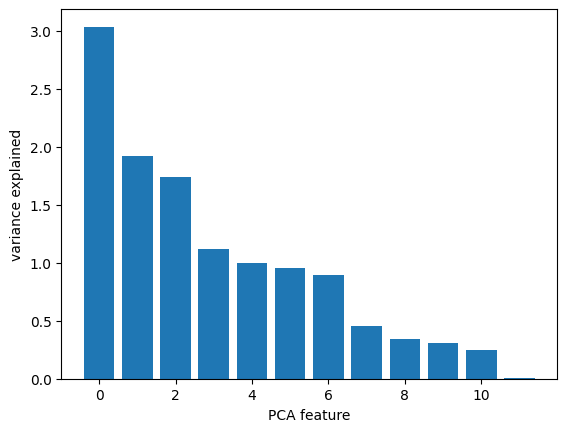

In [57]:

pca = PCA()
pca.fit_transform(df_train_scaled)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.ylabel('variance explained')
plt.xlabel('PCA feature')

**Create a pca dataframe based on 90% explained variance retained**

In [58]:

pca = PCA(n_components=.90).fit(df_train_scaled)
pca_train = pca.transform(df_train_scaled)
pca_test = pca.transform(df_test_scaled)
col_lst = []
for i in range(0,pca_train.shape[1]):
    col_lst.append(f'PC{i}')

df_pca_train = pd.DataFrame(pca_train,columns=col_lst)
df_pca_test = pd.DataFrame(pca_test,columns=col_lst)
df_pca_train.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,1.591607,2.639716,0.607073,1.937097,1.704908,-0.002423,-0.238307,-0.460655
1,1.627133,2.295267,1.642683,1.958127,1.709417,0.002393,-0.178525,-0.487520
2,1.592102,2.639638,0.610849,1.871574,1.579016,0.071865,-0.273707,-0.449017
3,1.627628,2.295188,1.646460,1.892605,1.583526,0.076681,-0.213925,-0.475882
4,1.592596,2.639559,0.614626,1.806052,1.453125,0.146152,-0.309107,-0.437378


Trying both the scaled & PCA data to see if we can maintain good accuracy level with less features

In [61]:
X = df_train_scaled
X_pca = df_pca_train
y = train_df_clean[['TotalTimeStopped_p20','TotalTimeStopped_p50','TotalTimeStopped_p80',
     'DistanceToFirstStop_p20','DistanceToFirstStop_p50','DistanceToFirstStop_p80']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.3, random_state=42)

**Create function to run different models and return rmse**

In [64]:

def modeling(X_train, X_test, y_train, y_test):
    models = []
    models.append(('LR', LinearRegression()))
    models.append(('KNN', KNeighborsRegressor()))
    models.append(('DT', DecisionTreeRegressor(random_state = 1)))
    models.append(('RF', RandomForestRegressor(random_state = 1)))
    models.append(('GB', MultiOutputRegressor(GradientBoostingRegressor(random_state = 1))))



    names = []
    rmses = []

    for name, model in models:

        model.fit (X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error (y_test, y_pred)
        rmse = np.sqrt(mse)
        print (f'{name} : mse {mse} - rmse {rmse}')
        names.append(name)
        rmses.append(rmse)
    return names, rmses

Run modeling function on scaled data

In [79]:
print ("Scaled Data Modeling :")
names, rmses = modeling (X_train, X_test, y_train, y_test)

Scaled Data Modeling :
LR : mse 5565.769392978463 - rmse 74.60408429153502
KNN : mse 4830.861906259786 - rmse 69.50440206389655
DT : mse 3134.463508694178 - rmse 55.98627964684007
RF : mse 1906.492702188375 - rmse 43.66340232034575
GB : mse 4752.9855407044315 - rmse 68.94189974684794


If we compare the result by rmse Random forests performs best so, we need to use Random Forests

In [80]:
print ("PCA Data Modeling :")
pca_names, pca_rmses = modeling (X_train_pca, X_test_pca, y_train_pca, y_test_pca)

PCA Data Modeling :
LR : mse 5572.58689443448 - rmse 74.64976151625991
KNN : mse 5463.722536761527 - rmse 73.91699761733784
DT : mse 6158.503627039008 - rmse 78.47613412394247
RF : mse 3210.3767736801105 - rmse 56.66018684826331
GB : mse 5408.698802478856 - rmse 73.54385632042187


Since RandomForest performed the best in our initial testing, we will start by trying to tune the RF parameters

In [82]:
rf_params = {}

In [84]:
rf_model = RandomForestRegressor(random_state = 1)

In [85]:
rf_cv = GridSearchCV(rf_model,
                    rf_params,
                    cv = 3).fit(X_train, y_train)

In [87]:
rf_cv.best_params_

{}

In [88]:
rf_tuned = rf_cv.best_estimator_
y_pred = rf_tuned.predict(X_test)
rf_mse = mean_squared_error(y_test, y_pred)
rf_rmse = np.sqrt(rf_mse)
print ('mse :', rf_mse)
print ('rmse :', rf_rmse)

mse : 1906.492702188375
rmse : 43.66340232034575


In [89]:
rf_pred = rf_tuned.predict(df_test_scaled)

In [90]:
rf_submission = pd.DataFrame (rf_pred, columns=range(0,6)).reset_index()
rf_submission = rf_submission.melt(id_vars='index', value_vars=range(0,6), value_name='Target')
rf_submission['TargetId'] = rf_submission['index'].astype(str) + '_' + rf_submission['variable'].astype(str)
rf_submission.sort_values(['index','variable'], inplace=True)

In [92]:
sample = pd.read_csv('/kaggle/input/bigquery-geotab-intersection-congestion/sample_submission.csv')
sample.shape

(11522010, 2)

In [93]:
rf_results = rf_submission.merge(sample[['TargetId']], on='TargetId', how='inner')
rf_results.shape

(11522010, 4)

In [94]:
rf_results[['TargetId','Target']].to_csv('rf_submission.csv', index=False)

In [95]:
submission = pd.read_csv('rf_submission.csv')

In [96]:
submission.head()

,TargetId,Target
0,0_0,2.010
1,0_1,9.810
2,0_2,28.770
3,0_3,10.714
4,0_4,38.926
